# Segmenting and Clustering Neighborhoods in New York

## Table of Contents
1. <a href="#item1"> Read in venues Data</a>
2. <a href="#item2"> Clustering Neighborhood </a>
3. <a href="#item3"> Examine Cluster </a>

<a id="item1"></a>

##  1. Read in venues data

In [2]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
venues =  pd.read_csv('NY_venues_supercategory.csv',usecols = [2,3,4,5,6,7,8,9])

In [4]:
venues.columns = ['Neighbourhood','Neighborhood Latitude', 'Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category', 'venue_Super_Category']

In [5]:
venues.head(1)

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,venue_Super_Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Food Drink


<a id="item2"></a>

## 2. Clustering Neighborhood
This cluster used K-mean clustering algorith and based on frequency of each venue super category in each neighborhood

### 2.1 change category feature into binary value

In [6]:
h_onehot = pd.get_dummies(venues[['venue_Super_Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
h_onehot['Neighbourhood'] = venues['Neighbourhood'] 
# move neighborhood column to the first column
fixed_columns = [h_onehot.columns[-1]] + list(h_onehot.columns[:-1])
h_onehot = h_onehot[fixed_columns]
h_onehot.head(1)

,Neighbourhood,Daily Enssential,Education,Entertainment,Fashion,Food Drink,Indoor Workout,Inner City Transportation,Inter City Transportation,Others,Outdoor Workout
0,Wakefield,0,0,0,0,1,0,0,0,0,0


In [7]:
h_grouped = h_onehot.groupby('Neighbourhood').mean()
h_grouped.head(1)

,Daily Enssential,Education,Entertainment,Fashion,Food Drink,Indoor Workout,Inner City Transportation,Inter City Transportation,Others,Outdoor Workout
Neighbourhood,,,,,,,,,,
Allerton,0.05,0.0,0.09,0.03,0.64,0.04,0.02,0.0,0.01,0.12


In [8]:
h_grouped = h_onehot.groupby('Neighbourhood').mean().reset_index()
h_cluster = h_grouped.drop(['Neighbourhood'],axis=1)
h_cluster.shape

(302, 10)

### 2.2 find elbow point for k-mean clustering 

In [9]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

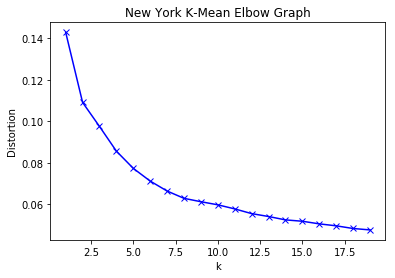

In [10]:
K = range (1,20)
distortion = []
for k in K:
    kmeantest = KMeans(n_clusters=k, random_state=0).fit(h_cluster)
    distortion.append(sum(np.min(cdist(h_cluster,kmeantest.cluster_centers_,'euclidean'),axis = 1))/h_cluster.shape[0])
distortion
plt.plot(K,distortion,'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('New York K-Mean Elbow Graph')
plt.show

### 2.3 K-mean cluster with chosen cluster number 4

In [11]:
kclusters = 4
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(h_cluster)
# check cluster labels generated for each row in the dataframe
label = kmeans.labels_


In [12]:
kmeans.cluster_centers_

array([[ 1.27734684e-01,  5.68181818e-04,  5.92638340e-02,
         5.00889328e-02,  6.01109190e-01,  4.89970356e-02,
         8.41897233e-03,  2.84090909e-03,  2.04545455e-02,
         8.05237154e-02],
       [ 6.98281983e-02,  7.98898072e-04,  8.43227732e-02,
         1.89854171e-02,  5.04152699e-01,  4.31312320e-02,
         1.79451194e-02,  3.18181818e-03,  3.17623682e-02,
         2.25891476e-01],
       [ 6.50333333e-02,  1.00000000e-03,  4.96000000e-02,
         2.32333333e-02,  7.18166667e-01,  3.21000000e-02,
         6.46666667e-03,  1.06666667e-03,  1.48333333e-02,
         8.85000000e-02],
       [ 6.90000000e-02,  2.50000000e-03,  2.46000000e-01,
         1.75000000e-02,  3.30500000e-01,  1.04000000e-01,
         9.50000000e-03, -4.33680869e-19,  8.05000000e-02,
         1.40500000e-01]])

In [13]:
h_cluster['Neighbourhood']=h_grouped['Neighbourhood']
h_cluster['label']=label
h_cluster.head(5)

,Daily Enssential,Education,Entertainment,Fashion,Food Drink,Indoor Workout,Inner City Transportation,Inter City Transportation,Others,Outdoor Workout,Neighbourhood,label
0,0.05,0.0,0.09,0.03,0.64,0.04,0.02,0.0,0.01,0.12,Allerton,2
1,0.24,0.0,0.06,0.07,0.49,0.04,0.00,0.0,0.00,0.10,Annadale,0
2,0.20,0.0,0.04,0.11,0.53,0.04,0.00,0.0,0.00,0.08,Arden Heights,0
3,0.14,0.0,0.05,0.14,0.60,0.04,0.00,0.0,0.01,0.02,Arlington,0
4,0.09,0.0,0.02,0.06,0.70,0.03,0.00,0.0,0.02,0.08,Arrochar,2


In [14]:
h_cluster.groupby(['label']).count()

,Daily Enssential,Education,Entertainment,Fashion,Food Drink,Indoor Workout,Inner City Transportation,Inter City Transportation,Others,Outdoor Workout,Neighbourhood
label,,,,,,,,,,,
0,88,88,88,88,88,88,88,88,88,88,88
1,44,44,44,44,44,44,44,44,44,44,44
2,150,150,150,150,150,150,150,150,150,150,150
3,20,20,20,20,20,20,20,20,20,20,20


In [15]:
h_NLL = venues.loc[:,['Neighbourhood','Neighborhood Latitude','Neighborhood Longitude']].drop_duplicates().sort_values('Neighbourhood')
h_NLL = h_NLL.reset_index(drop = True)
h_NLL.head()

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude
0,Allerton,40.865788,-73.859319
1,Annadale,40.538114,-74.178549
2,Arden Heights,40.549286,-74.185887
3,Arlington,40.635325,-74.165104
4,Arrochar,40.596313,-74.067124


In [16]:
h_merged = pd.DataFrame(h_cluster.loc[:,['label','Neighbourhood']])
h_merged.head(5)

,label,Neighbourhood
0,2,Allerton
1,0,Annadale
2,0,Arden Heights
3,0,Arlington
4,2,Arrochar


In [17]:
h_merged['Neighborhood Latitude']=h_NLL.iloc[:,1]
h_merged['Neighborhood Longitude']=h_NLL['Neighborhood Longitude']
h_merged.head(5)

,label,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude
0,2,Allerton,40.865788,-73.859319
1,0,Annadale,40.538114,-74.178549
2,0,Arden Heights,40.549286,-74.185887
3,0,Arlington,40.635325,-74.165104
4,2,Arrochar,40.596313,-74.067124


In [262]:
latitude = h_merged['Neighborhood Latitude'][0]
latitude

40.86578787802982

##  2.4 view clusters in map view

In [264]:
latitude = h_merged['Neighborhood Latitude'][0]
longitude = h_merged['Neighborhood Longitude'][0]
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(h_merged['Neighborhood Latitude'], h_merged['Neighborhood Longitude'], h_merged['Neighbourhood'], h_merged['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

<a id="item3"></a>

## 3. Examine Clusters

## 3.1 let view what are most populated venue category in those clusters and define cluster properties

In [265]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues =5
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = h_grouped['Neighbourhood']

for ind in np.arange(h_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(h_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(2)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Food Drink,Outdoor Workout,Entertainment,Daily Enssential,Indoor Workout
1,Annadale,Food Drink,Daily Enssential,Outdoor Workout,Fashion,Entertainment


In [266]:
h_pp = h_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'),on = 'Neighbourhood').drop(['Neighborhood Latitude','Neighborhood Longitude'],1)
h_pp.head(2)

,label,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2,Allerton,Food Drink,Outdoor Workout,Entertainment,Daily Enssential,Indoor Workout
1,0,Annadale,Food Drink,Daily Enssential,Outdoor Workout,Fashion,Entertainment


### Most Popular 5 Venues Category in Cluster 0

In [267]:
c_0 = h_pp.loc[h_pp['label']==0]
c_0.head(2)

,label,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,0,Annadale,Food Drink,Daily Enssential,Outdoor Workout,Fashion,Entertainment
2,0,Arden Heights,Food Drink,Daily Enssential,Fashion,Outdoor Workout,Indoor Workout


### Most Popular 5 Venues Category in Cluster 1

In [268]:
c_1 = h_pp.loc[h_pp['label']==1]
c_1.head(2)

,label,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,1,Arverne,Food Drink,Outdoor Workout,Daily Enssential,Inner City Transportation,Indoor Workout
10,1,Battery Park City,Food Drink,Outdoor Workout,Entertainment,Daily Enssential,Others


### Most Popular 5 Venues Category in Cluster 2

In [269]:
c_2 = h_pp.loc[h_pp['label']==2]
c_2.head(2)

,label,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2,Allerton,Food Drink,Outdoor Workout,Entertainment,Daily Enssential,Indoor Workout
4,2,Arrochar,Food Drink,Daily Enssential,Outdoor Workout,Fashion,Indoor Workout


### Most Popular 5 Venues Category in Cluster 3

In [270]:
c_3 = h_pp.loc[h_pp['label']==3]
c_3.head(2)

,label,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
43,3,Carnegie Hill,Food Drink,Entertainment,Outdoor Workout,Indoor Workout,Others
57,3,Clinton,Food Drink,Entertainment,Outdoor Workout,Indoor Workout,Daily Enssential


In [271]:
h_cluster_scp = h_cluster.groupby(['label']).mean()


### 3.2 Let view venues in each supercategory for each cluster

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
h_cluster_scp = h_cluster.groupby(['label']).mean()
h_cluster_scp

,Daily Enssential,Education,Entertainment,Fashion,Food Drink,Indoor Workout,Inner City Transportation,Inter City Transportation,Others,Outdoor Workout
label,,,,,,,,,,
0,0.127735,0.000568,0.059264,0.050089,0.601109,0.048997,0.008419,0.002841,0.020455,0.080524
1,0.069828,0.000799,0.084323,0.018985,0.504153,0.043131,0.017945,0.003182,0.031762,0.225891
2,0.065033,0.001000,0.049600,0.023233,0.718167,0.032100,0.006467,0.001067,0.014833,0.088500
3,0.069000,0.002500,0.246000,0.017500,0.330500,0.104000,0.009500,0.000000,0.080500,0.140500


In [20]:
h_cluster_scp = h_cluster_scp.reset_index()

In [21]:
lables_pie =h_cluster_scp.drop(['label'],1).columns

Text(0.5, 0.98, 'New York Neighborhood Clusters')

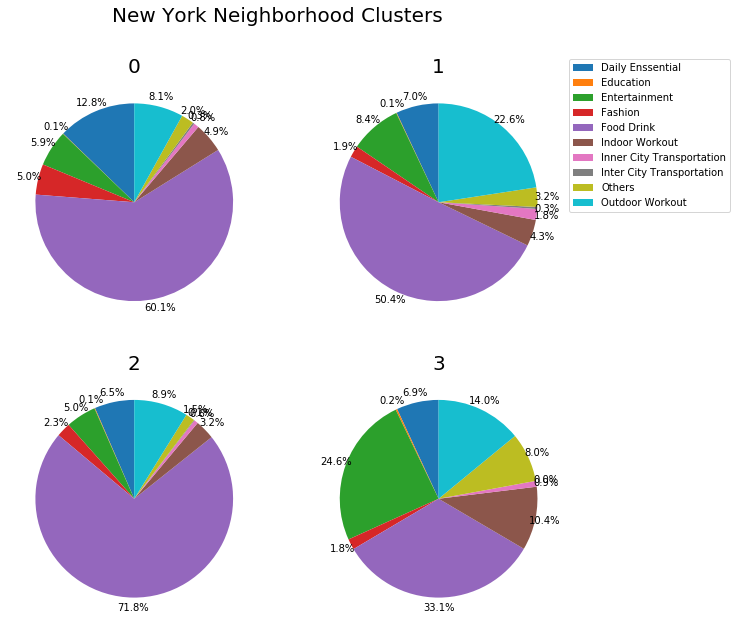

In [22]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for i, (idx,row) in enumerate(h_cluster_scp.set_index('label').iterrows()):
    
    ax = axes[i//2,i%2]
    #row = row[row.gt(row.sum()*.01)]
    ax.pie(row,labels=None,startangle=90,autopct = '%1.1f%%',pctdistance = 1.1)
    ax.set_title(idx,fontsize=20)
ax.legend(labels= lables_pie,loc = 'upper right',bbox_to_anchor = (1.7,2.3))
fig.suptitle('New York Neighborhood Clusters',fontsize =20)




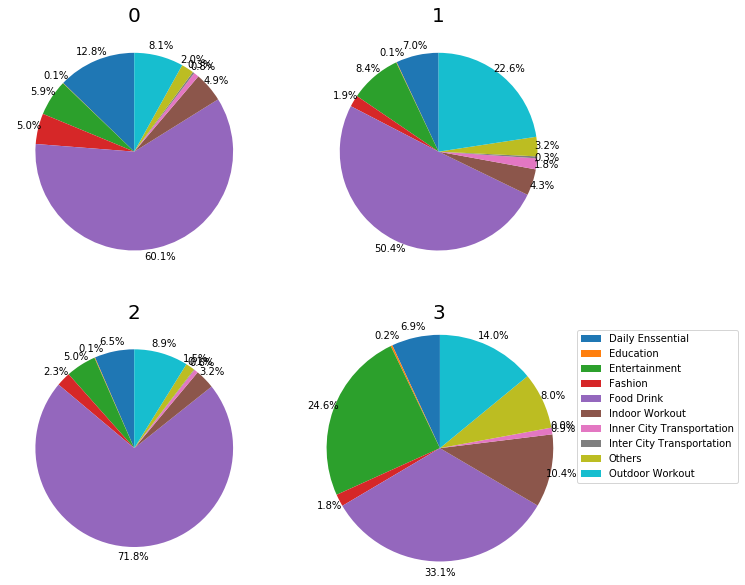

In [275]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for i, (idx,row) in enumerate(h_cluster_scp.set_index('label').iterrows()):
    
    ax = axes[i//2,i%2]
    #row = row[row.gt(row.sum()*.01)]
    ax.pie(row,labels=None,startangle=90,autopct = '%1.1f%%',pctdistance = 1.1)
    ax.set_title(idx,fontsize=20)
ax.axis('equal')
ax.legend(labels=c_pie.index,loc = 'upper right',bbox_to_anchor = (1.7,1))
